# Chapter 1. 철판 제조 공정 데이터를 활용한 분류모형 생성 및 성능 비교

## Step 0. 철판 제조 공정 데이터 소개 및 데이터 준비, 학습목표

**Steel Plates Faults 데이터는 1941개의 샘플을 가지며 아래의 종속변수들과 나머지 설명변수들로 구성됩니다.**

- 종속변수 (7개) - 어떠한 불량이 나타났는지를 나타내고, 다음과 같습니다.
 - Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults

- 설명변수 (27개) - 철판의 길이, 반짝이는 정도, 두께, 타입 등 등 다양한 변수들을 가집니다.
 - 첫번째 칼럼 X_Minimum ~ 27번째 칼럼 SigmoidOfAreas

- 데이터출처: https://www.kaggle.com/mahsateimourikia/faults-nna/notebooks



**제조 공정 데이터의 전반적 특성**

- 제조 공정 데이터는 주로 불량률을 예측하여 불량을 일으키는 원인을 제거하거나 재고를 예측하여 수요에 맞는 생산을 진행하는 등의 목적성을 가집니다.
- 다른 데이터에 비하여 데이터를 얻는 과정이 자동화되어 있는 경우가 많아 데이터 퀄리티가 높은 편이며 결측치가 적은 경향성을 가집니다.


### **학습목표**
```
- 각 모델들의 개괄적 이해 및 구축과정 학습.
- 파라미터를 최적화 시키는 GridSearch에 대한 이해 및 코딩작업 체화.
- 각 모델의 중요 파라미터에 대한 개괄적 이해.
- 파라미터의 변화에 따른 예측력 변화 경향성 파악.
- 최적의 모형 및 파라미터를 찾는 과정에 대한 계획 수립 및 수행.
``` 

**아래와 같이 데이터를 준비합니다.**

In [1]:
import pandas as pd 
import numpy as np

In [2]:
# 데이터를 읽어옵니다.
df = pd.read_csv("./data/Faults.NNA",  delimiter='\t', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [3]:
columnsOfdf = pd.read_csv('./data/Faults27x7_var', header=None)
columnsOfdf[0].head()

0       X_Minimum
1       X_Maximum
2       Y_Minimum
3       Y_Maximum
4    Pixels_Areas
Name: 0, dtype: object

In [4]:
df.columns = columnsOfdf[0]

In [5]:
# 칼럼명이 제대로 지정이 되었는지 여부와 데이터 구조를 파악합니다.
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [6]:
print(df.shape)

(1941, 34)


In [7]:
#Cpu의 개수를 확인합니다.
import os
n_cpu=os.cpu_count()
print("The number of cpus: ",n_cpu)
n_thread=n_cpu*2
print("Expected number of threads:",n_thread)

The number of cpus:  8
Expected number of threads: 16


## Step 1. 데이터 전처리 및 탐색적 데이터 분석

### 문제 1. 종속변수 범주화 (1) - boolean Seris로 이루어진 list 구성

- 7개의 종속변수들을 각 종속변수가 1인지 아닌지 여부를 알리는 boolean 논리 연산자로 이루어진 seris 형태로 변경합니다. 각 Seris의 길이는 1941입니다.
- 이 7개의 Seris를 list로 이어 붙여 길이 7짜리 list를 만들어 conditions라는 이름으로 저장합니다. 
- 여러 방법이 존재합니다. 방법 1,2는 코드를 제공드리며 풀어주실 문제는 방법3입니다.

In [8]:
## 방법 1. 논리적 연산자 &를 활용하여 생성합니다.
conditions=[(df['Pastry'] == 1) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0), 
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 1)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 1)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 1)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 1)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 1)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 1)]



In [9]:
conditions[0]

0        True
1        True
2        True
3        True
4        True
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Length: 1941, dtype: bool

In [10]:
## 방법 2. pandas.Series.astype을 활용합니다.
conditions=[df['Pastry'].astype(bool),
            df['Z_Scratch'].astype(bool),
            df['K_Scatch'].astype(bool),
            df['Stains'].astype(bool),
            df['Dirtiness'].astype(bool),
            df['Bumps'].astype(bool),
            df['Other_Faults'].astype(bool)]

In [11]:
## (문제) 방법 3. pandas.Series.astype과 map, lambda를 활용합니다
# conditions_bf에 각 변수들의 Seris로 list를 구성합니다.
# conditions_bf을 사용하고 map, lambda를 활용하여 conditions_bf의 각 원소에 astype 함수를 적용합니다.

condition_bf = df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]
conditions= condition_bf.apply(lambda x: x.astype('bool'), axis=0)
conditions

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1936,False,False,False,False,False,False,True
1937,False,False,False,False,False,False,True
1938,False,False,False,False,False,False,True
1939,False,False,False,False,False,False,True


### 문제 2. 종속변수 범주화 (2) - numpy.select를 활용한 범주화
- 범주화 시 범주명은 각 종속변수의 칼럼명을 그대로 활용합니다.
- (핵심) select 함수는 list 각 원소별로 TRUE인 것들의 값을 지정해줍니다.
- 범주화하여 기존 데이터프레임에 새로운 칼럼 'class'로 저장합니다.

In [12]:
choices = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [13]:
df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


In [14]:
classList = []
for i in range(df[choices].shape[0]):
    for col in df[choices].columns:
        if df.loc[i, col] == 1:
            classList.append(col)
            
df['class'] = classList

In [15]:
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,class
0,42,50,270900,270944,267,17,44,24220,76,108,...,-0.2913,0.5822,1,0,0,0,0,0,0,Pastry
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,-0.1756,0.2984,1,0,0,0,0,0,0,Pastry
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,-0.1228,0.2150,1,0,0,0,0,0,0,Pastry
3,853,860,369370,369415,176,13,45,18996,99,126,...,-0.1568,0.5212,1,0,0,0,0,0,0,Pastry
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,-0.1992,1.0000,1,0,0,0,0,0,0,Pastry


In [16]:
conditions.columns

Index(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps',
       'Other_Faults'],
      dtype='object', name=0)

In [17]:
## (문제) numpy.select를 사용하고 위에 정의해드린 choices를 인수로 활용하여 범주화를 진행합니다.

se_conditions = [df[cols] for cols in conditions.columns]
se_conditions = list(map(lambda x: x.astype('bool'), se_conditions))

zz = np.select(condlist=se_conditions, choicelist=choices)
len(zz)

1941

In [18]:
# 아래와 같이 class 칼럼이 생성되고 범주화 된 것을 확인할 수 있습니다.
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,class
0,42,50,270900,270944,267,17,44,24220,76,108,...,-0.2913,0.5822,1,0,0,0,0,0,0,Pastry
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,-0.1756,0.2984,1,0,0,0,0,0,0,Pastry
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,-0.1228,0.2150,1,0,0,0,0,0,0,Pastry
3,853,860,369370,369415,176,13,45,18996,99,126,...,-0.1568,0.5212,1,0,0,0,0,0,0,Pastry
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,-0.1992,1.0000,1,0,0,0,0,0,0,Pastry


### 문제 3. EDA - 결측치 확인하기

In [19]:
# (문제) pandas.isnull를 활용해 모든 변수에 대하여 결측치가 얼마나 존재하는지를 파악합니다.

df.isna().sum(axis=0)

0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
class                    0
dtype: int64

### 문제 4. EDA - 기술통계량 파악하기
- pandas.DataFrame.describe를 활용해 기술통계량을 파악합니다.
 - min과 25% Quantile, max와 75% Quantile을 비교해 이상치 존재가능성에 대해서 파악할 수 있습니다.
 - mean과 50% Quantile을 비교하여 분포의 치우침 정도를 파악할 수 있습니다.
 - 범주형 변수에 대해서는 정보가 제한적입니다
- pandas.Series.value_counts를 활용해 범주화한 종속변수의 기술통계량을 파악합니다.
 - 어떠한 불량타입이 많이 분포하고 적게 분포하는지 파악할 수 있습니다.
 - 적게 분포하는 불량타입의 경우는 예측모형을 구축하는 것이 상대적으로 더 어려울 것입니다.

In [20]:
# (문제) pandas.DataFrame.describe를 활용해 기술통계량을 파악합니다.

df.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# (문제) pandas.Series.value_counts를 활용해 범주화한 종속변수의 기술통계량을 파악합니다.

df['class'].value_counts()
# stains, dirtiness 다른 falut에 비해 너무 작음
# 1. 다른 범주랑 역든가
# 2. 제외하고 예측모형을 만들든가

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: class, dtype: int64

### 문제 5. 산점도를 통한 변수간의 상관관계 파악

In [22]:
import matplotlib.pyplot as plt

In [23]:
color_code = {'Pastry':'Red', 'Z_Scratch':'Blue', 'K_Scatch':'Green', 'Stains':'Black', 'Dirtiness':'Pink', 'Bumps':'Brown', 'Other_Faults':'Gold'}

In [24]:
# (문제) for문과 위에 정의해드린 dictionary를 활용하여 데이터의 각 행에 해당하는 color값을 지정하는 list를 생성하여 color_list에 저장합니다.

color_list = [color_code.get(i) for i in df.loc[:, 'class']]
color_list[:5]

['Red', 'Red', 'Red', 'Red', 'Red']

array([[<AxesSubplot:xlabel='X_Minimum', ylabel='X_Minimum'>,
        <AxesSubplot:xlabel='X_Maximum', ylabel='X_Minimum'>,
        <AxesSubplot:xlabel='Y_Minimum', ylabel='X_Minimum'>, ...,
        <AxesSubplot:xlabel='Dirtiness', ylabel='X_Minimum'>,
        <AxesSubplot:xlabel='Bumps', ylabel='X_Minimum'>,
        <AxesSubplot:xlabel='Other_Faults', ylabel='X_Minimum'>],
       [<AxesSubplot:xlabel='X_Minimum', ylabel='X_Maximum'>,
        <AxesSubplot:xlabel='X_Maximum', ylabel='X_Maximum'>,
        <AxesSubplot:xlabel='Y_Minimum', ylabel='X_Maximum'>, ...,
        <AxesSubplot:xlabel='Dirtiness', ylabel='X_Maximum'>,
        <AxesSubplot:xlabel='Bumps', ylabel='X_Maximum'>,
        <AxesSubplot:xlabel='Other_Faults', ylabel='X_Maximum'>],
       [<AxesSubplot:xlabel='X_Minimum', ylabel='Y_Minimum'>,
        <AxesSubplot:xlabel='X_Maximum', ylabel='Y_Minimum'>,
        <AxesSubplot:xlabel='Y_Minimum', ylabel='Y_Minimum'>, ...,
        <AxesSubplot:xlabel='Dirtiness', ylabel='Y_Mini

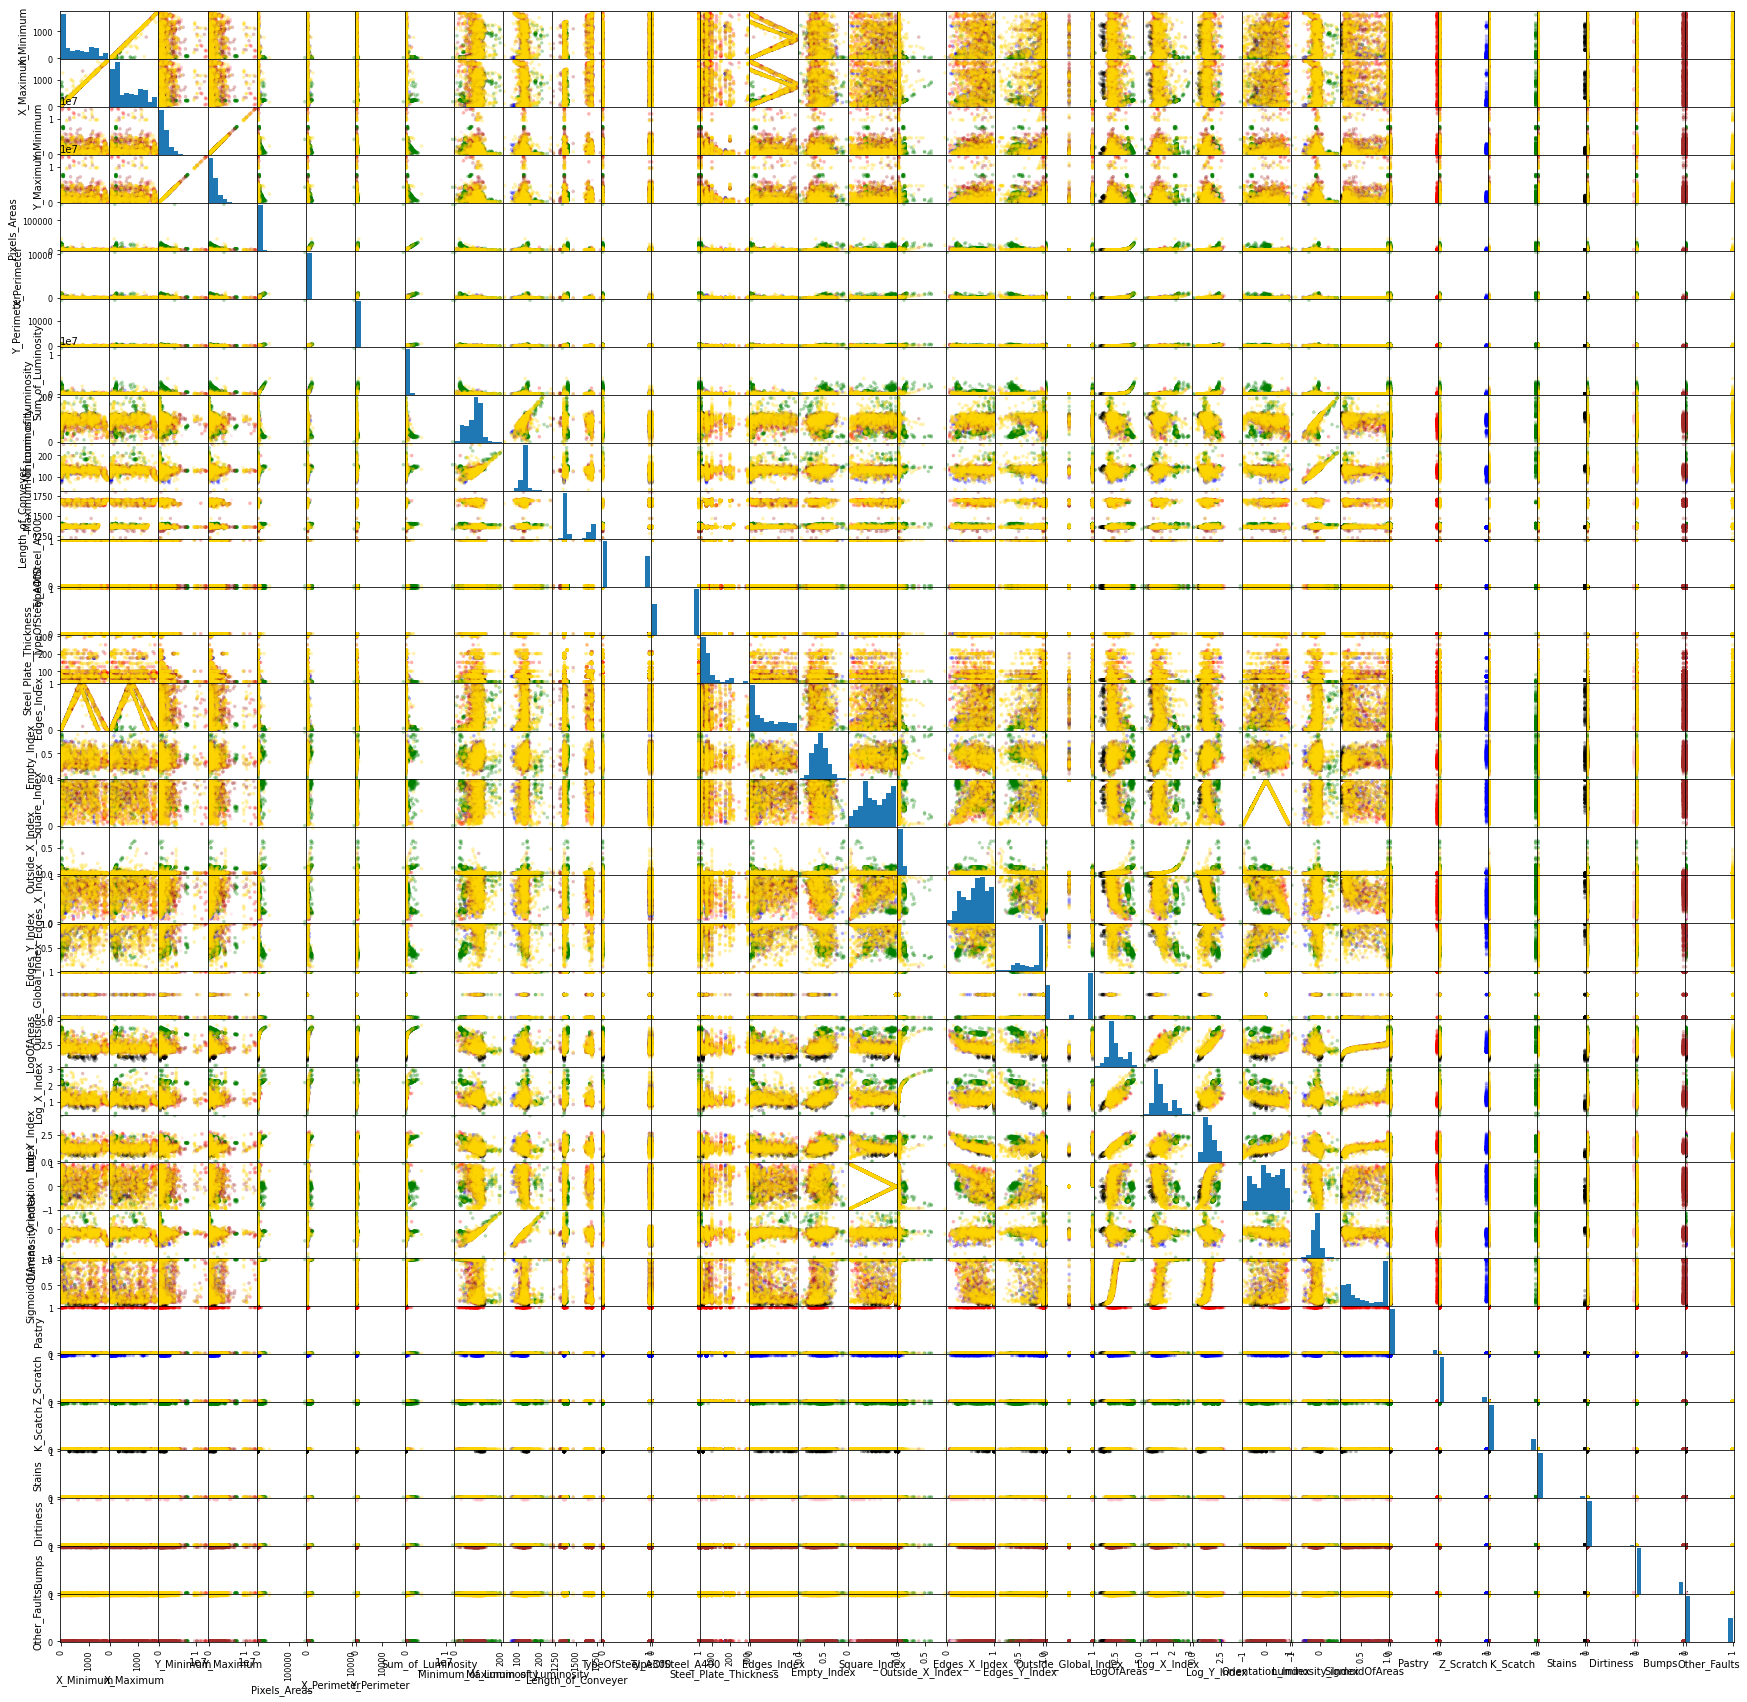

In [25]:
# (문제) pandas.plotting.scatter_matrix, 위에서 만든 color_list를 활용해 scatter plot을 그리고 대각원소에는 히스토그램을 출력해봅니다. figsize= [30,30], alpha=0.3,s = 50 으로 지정합니다.

pd.plotting.scatter_matrix(df.loc[:, df.columns!='class'], c=color_list, figsize=[30, 30], alpha=0.3, s=50, diagonal='hist')

### 문제 6. 범주형 변수의 분포 시각화

In [26]:
import seaborn as sns
sns.set_style("white")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'The number of Defects by Defect type')

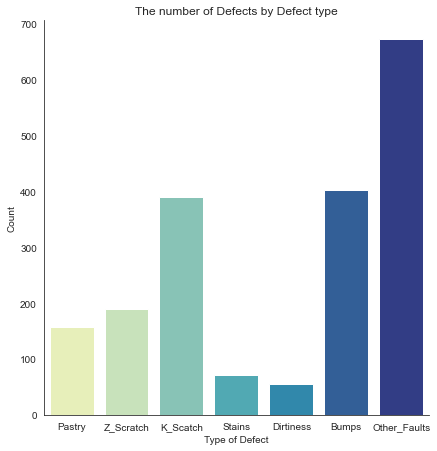

In [27]:
# (문제) seaborn.factorplot을 활용하여 Barplot으로 "class" 변수의 카운트를 표현합니다. 적절한 x축, y축, plot의 title까지 지정해줍니다.

g=sns.factorplot(x='class', data=df, kind='count', palette='YlGnBu', size=6)
plt.xlabel('Type of Defect')
plt.ylabel('Count')
plt.title('The number of Defects by Defect type')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


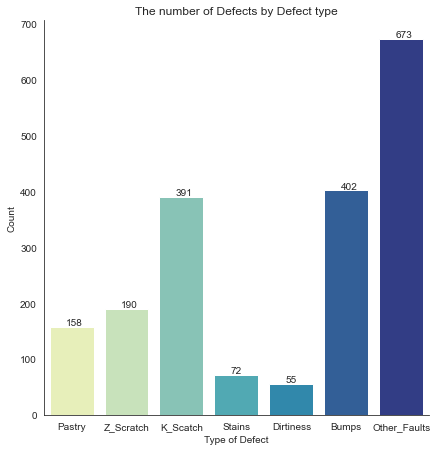

In [28]:
##### 이전 cell에서 완성한 코드를 복사 붙여넣기 합니다. 

# (문제) Barplot의 bar 상단에 값을 text로 달아줍니다.

g=sns.factorplot(x='class', data=df, kind='count', palette='YlGnBu', size=6)
plt.xlabel('Type of Defect') 
plt.ylabel('Count')
plt.title('The number of Defects by Defect type')


for p in g.ax.patches:
    g.ax.annotate(text=p.get_height(), xy=(p.get_x() + 0.3, p.get_height() + 3))


### 문제 7. 상관계수를 활용한 변수간의 상관관계 파악

In [29]:
df_corTarget = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]

In [30]:
# (문제) df_corTarget에 대하여, pandas.DataFrame.corr 을 활용해 correlation을 구한 뒤 corr에 저장. 
corr = df_corTarget.corr()
corr

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,,,,,,,,,,,,,,,,,,,,,
X_Minimum,1.000000,0.988314,0.041821,0.041807,-0.307322,-0.258937,-0.118757,-0.339045,0.237637,-0.075554,...,-0.361160,0.154778,0.367907,0.147282,-0.428553,-0.437944,-0.326851,0.178585,-0.031578,-0.355251
X_Maximum,0.988314,1.000000,0.052147,0.052135,-0.225399,-0.186326,-0.090138,-0.247052,0.168649,-0.062392,...,-0.214930,0.149259,0.271915,0.099253,-0.332169,-0.324012,-0.265990,0.115019,-0.038996,-0.286736
Y_Minimum,0.041821,0.052147,1.000000,1.000000,0.017670,0.023843,0.024150,0.007362,-0.065703,-0.067785,...,0.054165,0.066085,-0.036543,-0.062911,0.044952,0.070406,-0.008442,-0.086497,-0.090654,0.025257
Y_Maximum,0.041807,0.052135,1.000000,1.000000,0.017840,0.024038,0.024380,0.007499,-0.065733,-0.067776,...,0.054185,0.066051,-0.036549,-0.062901,0.044994,0.070432,-0.008382,-0.086480,-0.090666,0.025284
Pixels_Areas,-0.307322,-0.225399,0.017670,0.017840,1.000000,0.966644,0.827199,0.978952,-0.497204,0.110063,...,0.588606,-0.294673,-0.463571,-0.109655,0.650234,0.603072,0.578342,-0.137604,-0.043449,0.422947
X_Perimeter,-0.258937,-0.186326,0.023843,0.024038,0.966644,1.000000,0.912436,0.912956,-0.400427,0.111363,...,0.517098,-0.293039,-0.412100,-0.079106,0.563036,0.524716,0.523472,-0.101731,-0.032617,0.380605
Y_Perimeter,-0.118757,-0.090138,0.024150,0.024380,0.827199,0.912436,1.000000,0.704876,-0.213758,0.061809,...,0.209160,-0.195162,-0.136723,0.013438,0.294040,0.228485,0.344378,0.031381,-0.047778,0.191772
Sum_of_Luminosity,-0.339045,-0.247052,0.007362,0.007499,0.978952,0.912956,0.704876,1.000000,-0.540566,0.136515,...,0.658339,-0.327728,-0.529745,-0.121090,0.712128,0.667736,0.618795,-0.158483,-0.014067,0.464248
Minimum_of_Luminosity,0.237637,0.168649,-0.065703,-0.065733,-0.497204,-0.400427,-0.213758,-0.540566,1.000000,0.429605,...,-0.487574,0.252256,0.316610,0.035462,-0.678762,-0.567655,-0.588208,0.057123,0.669534,-0.514797


<ipython-input-31-7fab10ea4ba0>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:xlabel='0', ylabel='0'>

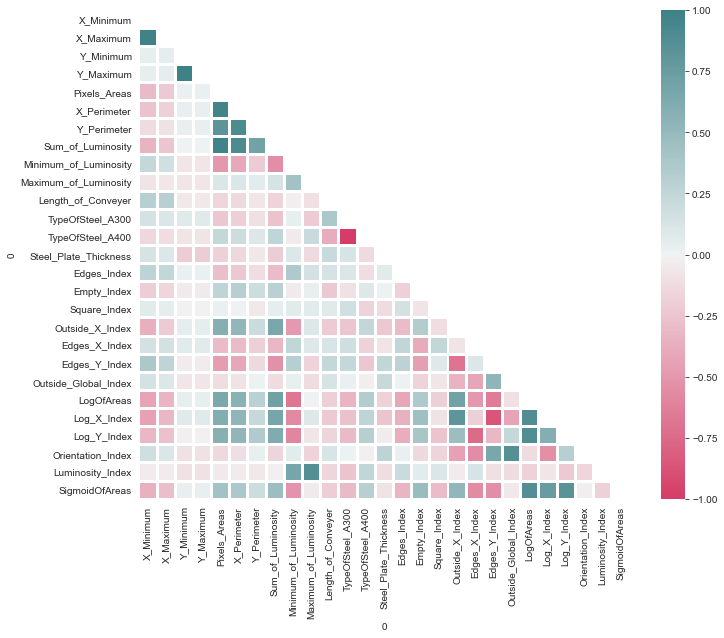

In [31]:
# heatmap을 그리기 위한 파라미터들 설정
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # 그래프 반만 출력하는 mask 생성

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(1,200, as_cmap=True)

# (문제) 저장해둔 corr과 mask, cmap을 활용하여 correlation을 표현하는 heatmap을 그립니다. correlation에 맞게 최대, 최소, 중간값을 지정해줍니다.
# linewidths=2로 설정합니다. 그림 크기는 figsize=(11,9)로 설정합니다.

sns.heatmap(corr, cmap=cmap, linewidths=2, mask=mask, vmax=1 , vmin=-1, center=0)

### 문제 8. Training, Test set 분리하기

In [32]:
x = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300',  'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]
y = df['K_Scatch']  # K_Scratch만 분류

In [33]:
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

In [34]:
# (문제) sklearn.model_selection.train_test_split을 활용하여, x_train, x_test, y_train, y_test로 데이터를 나눕니다
# 그 비율은 8:2로 합니다. y값에 따라 stratify하여 나눕니다.

X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2)

In [35]:
# (문제) pandas.DataFrame.apply를 활용하여  x_train과 x_test를 표준화합니다.
X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)

In [36]:
X_train.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,...,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03
mean,-4.202681e-17,7.994035e-17,1.502235e-17,-1.137406e-17,1.641728e-17,-1.605960e-17,1.847391e-17,-4.399402e-18,-3.750222e-17,-7.619013e-16,...,6.137702e-17,4.342174e-17,-2.750878e-16,1.191058e-17,3.841429e-17,-6.516837e-17,4.059611e-16,-2.466169e-17,1.516542e-17,3.399343e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,...,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.095508e+00,-1.232491e+00,-9.167641e-01,-9.167786e-01,-3.488552e-01,-3.412978e-01,-1.749753e-01,-3.917644e-01,-2.630744e+00,-3.188974e+00,...,-5.209950e-01,-2.482526e+00,-3.019814e+00,-1.195978e+00,-2.775979e+00,-2.135539e+00,-3.093681e+00,-2.109023e+00,-5.841756e+00,-1.366168e+00
25%,-9.985245e-01,-8.585107e-01,-6.678155e-01,-6.678217e-01,-3.336114e-01,-3.010743e-01,-1.495906e-01,-3.740471e-01,-6.766769e-01,-3.363276e-01,...,-4.388929e-01,-7.746578e-01,-9.117353e-01,-1.195978e+00,-7.108854e-01,-6.903730e-01,-7.014650e-01,-8.246790e-01,-4.382826e-01,-9.831216e-01
50%,-2.673444e-01,-2.856054e-01,-2.567728e-01,-2.567904e-01,-3.176241e-01,-2.670390e-01,-1.263212e-01,-3.555790e-01,1.607805e-01,-1.748571e-01,...,-3.905976e-01,9.700631e-02,5.677528e-01,8.802615e-01,-3.214778e-01,-3.262903e-01,-1.628174e-01,2.580272e-02,-1.370233e-02,-2.623900e-01
75%,9.188027e-01,9.064553e-01,2.979701e-01,2.980354e-01,-2.071532e-01,-9.608907e-02,-9.445673e-03,-2.414077e-01,6.648058e-01,5.248486e-01,...,-1.756835e-01,7.567332e-01,7.917628e-01,8.802615e-01,5.089551e-01,3.816137e-01,7.285002e-01,8.460103e-01,4.458671e-01,1.245187e+00
max,2.146786e+00,2.167145e+00,6.436906e+00,6.436843e+00,2.802929e+01,3.198294e+01,3.822155e+01,2.189230e+01,3.665695e+00,6.606906e+00,...,1.355548e+01,1.581392e+00,7.917628e-01,8.802615e-01,3.435586e+00,3.597781e+00,6.346395e+00,1.831823e+00,5.200022e+00,1.245780e+00


## Step 2. 로지스틱 분류 모형


### 문제 9. [로지스틱 회귀분석] 로지스틱 기본 모형 만들기

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics

In [38]:
# (문제) 로지스틱 회귀분석 모형을 만들어 lm에 저장합니다. solver는 'liblinear'로 설정합니다.

lm = LogisticRegression(solver='liblinear') # L1(Ridge) / L2(Lasso) 둘다 가능

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### 문제 10. [로지스틱 회귀분석] Grid Search 구축 (Lidge, Lasso Penalty / Threshold)

In [39]:
# (문제) 로지스틱에서 고려해야할 Penalty의 형태 (Ridge, Lasso), regularization parameter range를 설정하여 이를 parameters에 dictionary 형태로 저장합니다.

params = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10],
    'tol' : [1e-4, 1e-2, 1, 1e2]
}

In [40]:
# (문제) sklearn.model_selection.GridSearchCV를 활용해 cv값 10, n_jobs값은 n_thread로, scoreing은 "accuracy"로 Grid Search를 세팅하고 이를 GSLR에 저장합니다.

grid_model = GridSearchCV(lm, param_grid=params, cv=10, n_jobs=-1, scoring='accuracy')

In [41]:
# (문제) Grid Search를 fit함수를 활용하여 수행합니다.
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.0001, 0.01, 1, 100.0]},
             scoring='accuracy')

In [42]:
# 최적의 파라미터 값 및 정확도 (Accuracy) 출력
print('final params', grid_model.best_params_)   
print('best score', grid_model.best_score_)  

final params {'C': 10, 'penalty': 'l1', 'tol': 0.0001}
best score 0.9742431761786602


In [43]:
df['class'].value_counts()['K_Scatch'] / df['class'].value_counts().values.sum()

0.20144255538382277

### 문제 11. [로지스틱 회귀분석] 모형 평가 및 최적 로지스틱 모형 구축

In [44]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장합니다.
y_pred = grid_model.predict(X_test)

In [45]:
# (문제) sklearn.metrics.confusion_matrix 활용하여 confusion_matrix를 구하고 이를 출력합니다.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       311
           1       0.85      0.94      0.89        78

    accuracy                           0.95       389
   macro avg       0.92      0.95      0.93       389
weighted avg       0.96      0.95      0.95       389



In [46]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = grid_model.cv_results_['mean_test_score']
stds = grid_model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.944 (+/-0.033) for {'C': 0.01, 'penalty': 'l1', 'tol': 0.0001}
0.947 (+/-0.029) for {'C': 0.01, 'penalty': 'l1', 'tol': 0.01}
0.943 (+/-0.039) for {'C': 0.01, 'penalty': 'l1', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.01, 'penalty': 'l1', 'tol': 100.0}
0.952 (+/-0.034) for {'C': 0.01, 'penalty': 'l2', 'tol': 0.0001}
0.952 (+/-0.034) for {'C': 0.01, 'penalty': 'l2', 'tol': 0.01}
0.954 (+/-0.032) for {'C': 0.01, 'penalty': 'l2', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.01, 'penalty': 'l2', 'tol': 100.0}
0.962 (+/-0.040) for {'C': 0.05, 'penalty': 'l1', 'tol': 0.0001}
0.961 (+/-0.039) for {'C': 0.05, 'penalty': 'l1', 'tol': 0.01}
0.954 (+/-0.035) for {'C': 0.05, 'penalty': 'l1', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.05, 'penalty': 'l1', 'tol': 100.0}
0.962 (+/-0.042) for {'C': 0.05, 'penalty': 'l2', 'tol': 0.0001}
0.962 (+/-0.042) for {'C': 0.05, 'penalty': 'l2', 'tol': 0.01}
0.959 (+/-0.036) for {'C': 0.05, 'penalty': 'l2', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.05, 'penalty': 'l2', 'tol':

## Step 3. 의사결정나무 모형

### 문제 12. [의사결정나무] 의사결정나무 기본 모형 만들기

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
# (문제) 의사결정나무 모형을 만들어 dt에 저장합니다.

dt = DecisionTreeClassifier()

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### 문제 13. [의사결정나무] Grid Search 구축 (Loss function / Prunning)

In [49]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

In [50]:
# (문제) 의사결정나무에서 고려해야할 criterion, min_samples_split, max_depth, min_samples_leaf, max_features 등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.

params = {
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : list(range(10, 30, 5)),
    'max_depth' : list(range(20, 40, 2))
}

### 문제 14. [의사결정나무]  모형 평가 및 최적 의사결정나무 구축

In [51]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.

import warnings
warnings.filterwarnings('ignore')

grid_dt = GridSearchCV(dt, params, cv=10)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 22, 24, 26, 28, 30, 32, 34, 36, 38],
                         'min_samples_split': [10, 15, 20, 25]})

In [52]:
grid_dt.score(X_test, y_test)

0.9665809768637532

In [53]:
# Train에서의 종속변수의 분포
print(y_train.value_counts())

0    1239
1     313
Name: K_Scatch, dtype: int64


In [54]:
# 최적의 파라미터 값 및 정확도 (Accuracy) 출력
print('final params', grid_dt.best_params_)   
print('best score', grid_dt.best_score_)  

final params {'criterion': 'entropy', 'max_depth': 28, 'min_samples_split': 25}
best score 0.9690942928039703


In [55]:
y_pred = grid_dt.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       311
           1       0.87      0.97      0.92        78

    accuracy                           0.97       389
   macro avg       0.93      0.97      0.95       389
weighted avg       0.97      0.97      0.97       389



[Text(862.3125, 625.1400000000001, 'Log_X_Index <= 1.467\nentropy = 0.725\nsamples = 1552\nvalue = [1239, 313]'),
 Text(716.625, 570.7800000000001, 'Steel_Plate_Thickness <= -0.617\nentropy = 0.289\nsamples = 1284\nvalue = [1219, 65]'),
 Text(605.25, 516.4200000000001, 'Luminosity_Index <= 1.768\nentropy = 0.741\nsamples = 305\nvalue = [241, 64]'),
 Text(490.5, 462.06000000000006, 'LogOfAreas <= 0.943\nentropy = 0.593\nsamples = 279\nvalue = [239, 40]'),
 Text(369.0, 407.70000000000005, 'X_Maximum <= -0.204\nentropy = 0.444\nsamples = 260\nvalue = [236, 24]'),
 Text(234.0, 353.34000000000003, 'Length_of_Conveyer <= -0.463\nentropy = 0.686\nsamples = 115\nvalue = [94, 21]'),
 Text(144.0, 298.98, 'Edges_X_Index <= 0.374\nentropy = 0.581\nsamples = 108\nvalue = [93, 15]'),
 Text(72.0, 244.62, 'Y_Maximum <= -0.871\nentropy = 0.115\nsamples = 65\nvalue = [64, 1]'),
 Text(36.0, 190.26, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(108.0, 190.26, 'entropy = 0.0\nsamples = 63\nvalue = [

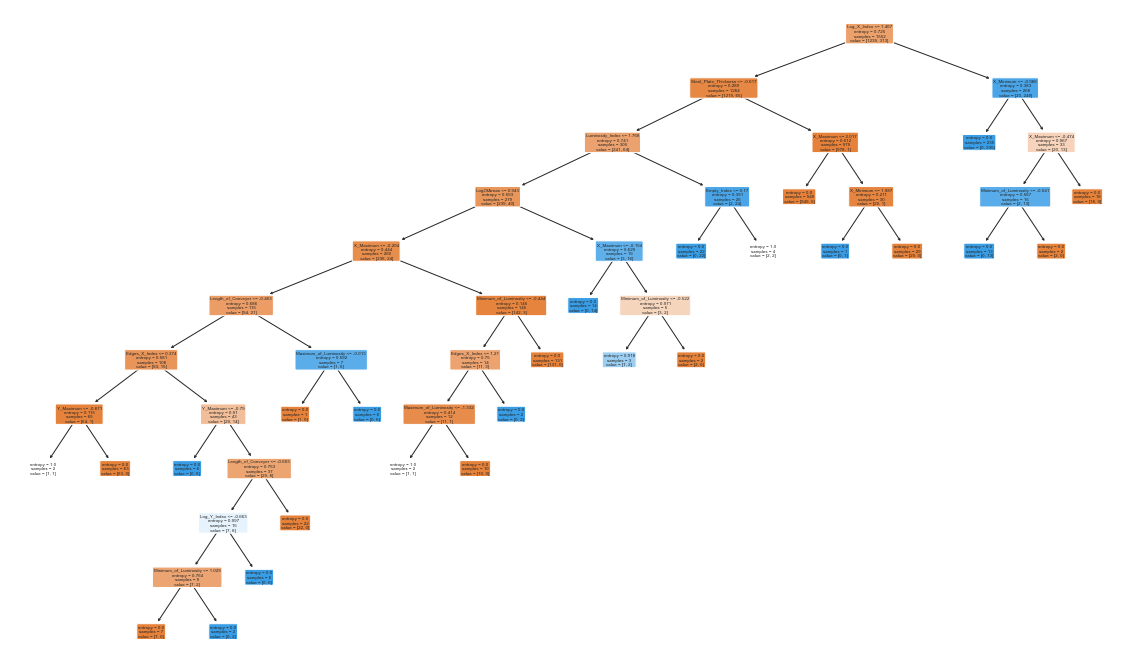

In [56]:
# 트리 시각화
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

dt2=DecisionTreeClassifier(criterion='entropy',max_depth=None,max_features=None,min_samples_leaf=1,min_samples_split=5)
dt2.fit(X_train,y_train)
plt.figure(figsize=(20, 12))
plot_tree(dt2, feature_names=X_train.columns,
         filled=True, 
         rounded=True)

## Step 4. Random Forest

- Random Forest는 아래의 Bagging과 Drop-out을 활용하여 의사결정나무의 변동성을 완화시키고 예측력을 높인 모델이다.
 - Bootstrapping: 복원추출을 통하여 샘플 구성이 조금씩 다른 여러 데이터셋을 생성해냄.
 - Aggregating: 여러 모형의 결과를 통합하여 모형의 변동성을 낮춤.
 - Drop-out: Tree를 구성할 때 변수를 일부 탈락시킴. Tree간의 correlation을 감소시켜 이 또한 모형의 변동성을 낮춤.

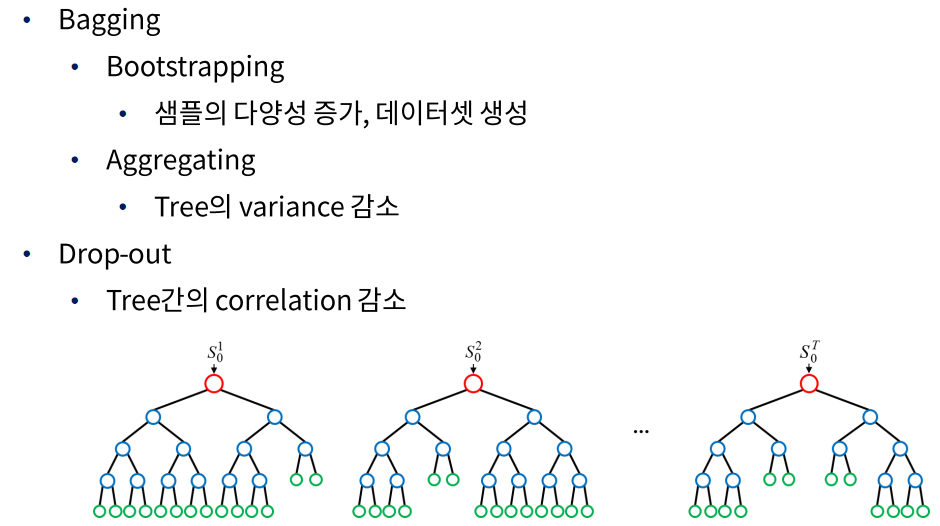

### 문제 15. [Random Forest]  Random Forest 기본 모형 만들기

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
# (문제) Random Forest 모형을 만들어 rf에 저장합니다.

model_rf = RandomForestClassifier()

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 문제 16. [Random Forest] Grid Search 구축 (Loss function / Prunning / 변수 선택 / Tree 개수)

In [59]:
# (문제) Random Forest에서 고려해야할 n_estimators, min_samples_split, max_depth, min_samples_leaf, max_features 등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.

params = {
    'n_estimators' : [50, 100, 150],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 5],
    'max_depth' : [None, 2, 5, 7],
    'min_samples_leaf' : [1, 3, 10],
    'max_features' : [None, 'sqrt']
}

grid_rf = GridSearchCV(model_rf, params, cv=3)

In [60]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 7],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 150]})

In [61]:
# 최적의 파라미터 값 및 정확도 (Accuracy) 출력
print('final params', grid_rf.best_params_)   
print('best score', grid_rf.best_score_)  

final params {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
best score 0.9826080570761421


### 문제 17. [Random Forest] 모형 평가 및 최적  Random Forest 구축

In [62]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
y_pred = grid_rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       311
           1       0.96      1.00      0.98        78

    accuracy                           0.99       389
   macro avg       0.98      1.00      0.99       389
weighted avg       0.99      0.99      0.99       389



In [63]:
grid_rf.score(X_test, y_test)

0.9922879177377892

In [87]:
best_rf = RandomForestClassifier(criterion='entropy',
                                max_depth=None,
                                max_features='sqrt',
                                min_samples_split=2,
                                min_samples_leaf=1)
best_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt')

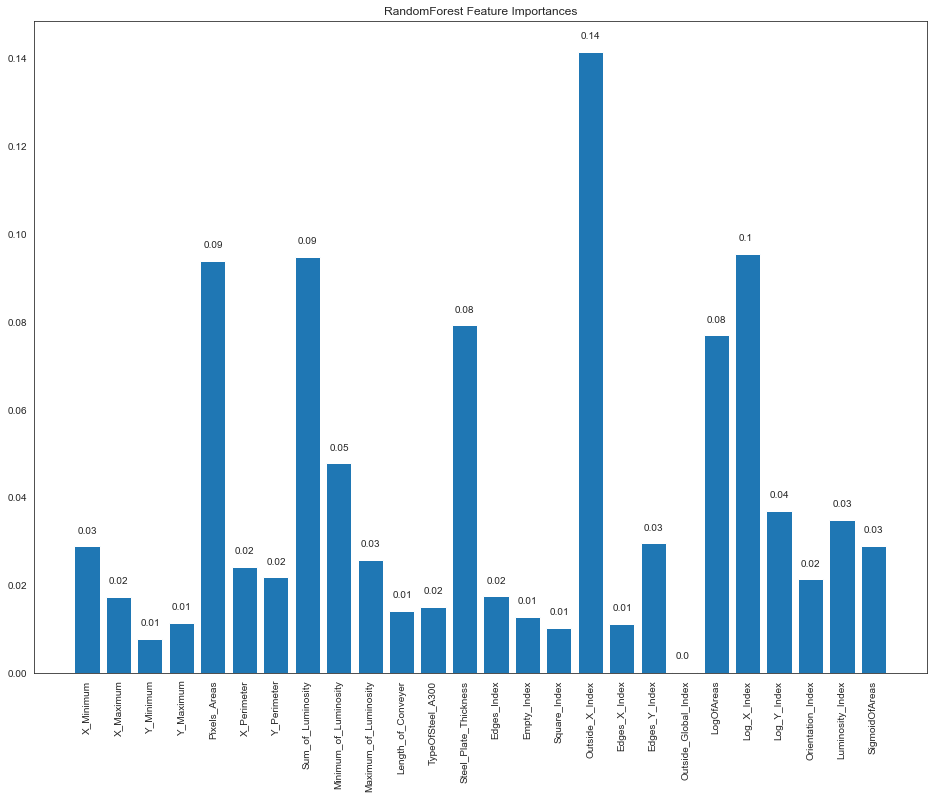

In [106]:
plt.figure(figsize=(16, 12))
plt.bar(height=best_rf.feature_importances_, x=X_train.columns)
plt.xticks(rotation=90)
plt.title('RandomForest Feature Importances')
for i,h in enumerate(best_rf.feature_importances_):
    plt.annotate(text=round(h, 2), xy=(i-0.3, h + 0.003))
plt.show()

## Step 5. Support Vector Machine

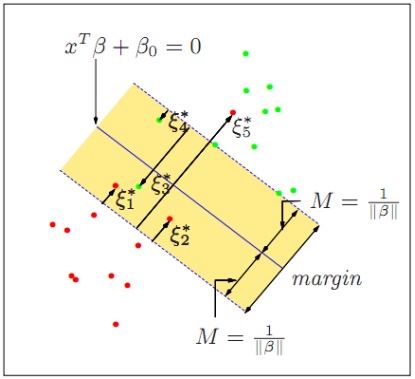

- 노란색 margin을 최대화하는 boundary를 찾는 것이 목표.
- Error를 허용하는 정도를 C로 표현한다.
 - C가 크면 Error를 많이 허용하고, C가 작을 수록 Error를 적게 허용한다.

Image reference: Fastcampus 머신러닝과 데이터 분석 A-Z 




### 문제 18. [SVM] Support Vector Machine 기본 모형 만들기

In [72]:
from sklearn.svm import SVC

In [73]:
# (문제) Support Vector Machine을 만들어 svc에 저장합니다.

model_svm = SVC()

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

### 문제 19. [SVM] Grid Search 구축 (Regularization / Kernel / Gamma)

In [76]:
np.

TypeError: 'float' object cannot be interpreted as an integer

In [78]:
# (문제) Support Vector Machine에서 고려해야할 C, kernel, gamma 등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.

params = {
    'C' : [0.01, 0.1, 0.5, 1, 5, 10],
    'kernel' : ['linear', 'rbf', 'poly'],
    'gamma' : [0.1, 1, 5, 10]
}

### 문제 20. [SVM] 모형 평가 및 최적 Support Vector Machine 구축

In [79]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.

grid_svm = GridSearchCV(model_svm, param_grid=params, cv=10, n_jobs=-1)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10],
                         'gamma': [0.1, 1, 5, 10],
                         'kernel': ['linear', 'rbf', 'poly']})

In [81]:
# 최적의 파라미터 값 및 정확도 (Accuracy) 출력
print('final params', grid_svm.best_params_)   
print('best score', grid_svm.best_score_)  

final params {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
best score 0.9845244003308521


In [85]:
grid_svm.score(X_test, y_test)

0.987146529562982

In [82]:
y_pred = grid_svm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       311
           1       0.96      0.97      0.97        78

    accuracy                           0.99       389
   macro avg       0.98      0.98      0.98       389
weighted avg       0.99      0.99      0.99       389



## Step 6. 신경망 모형

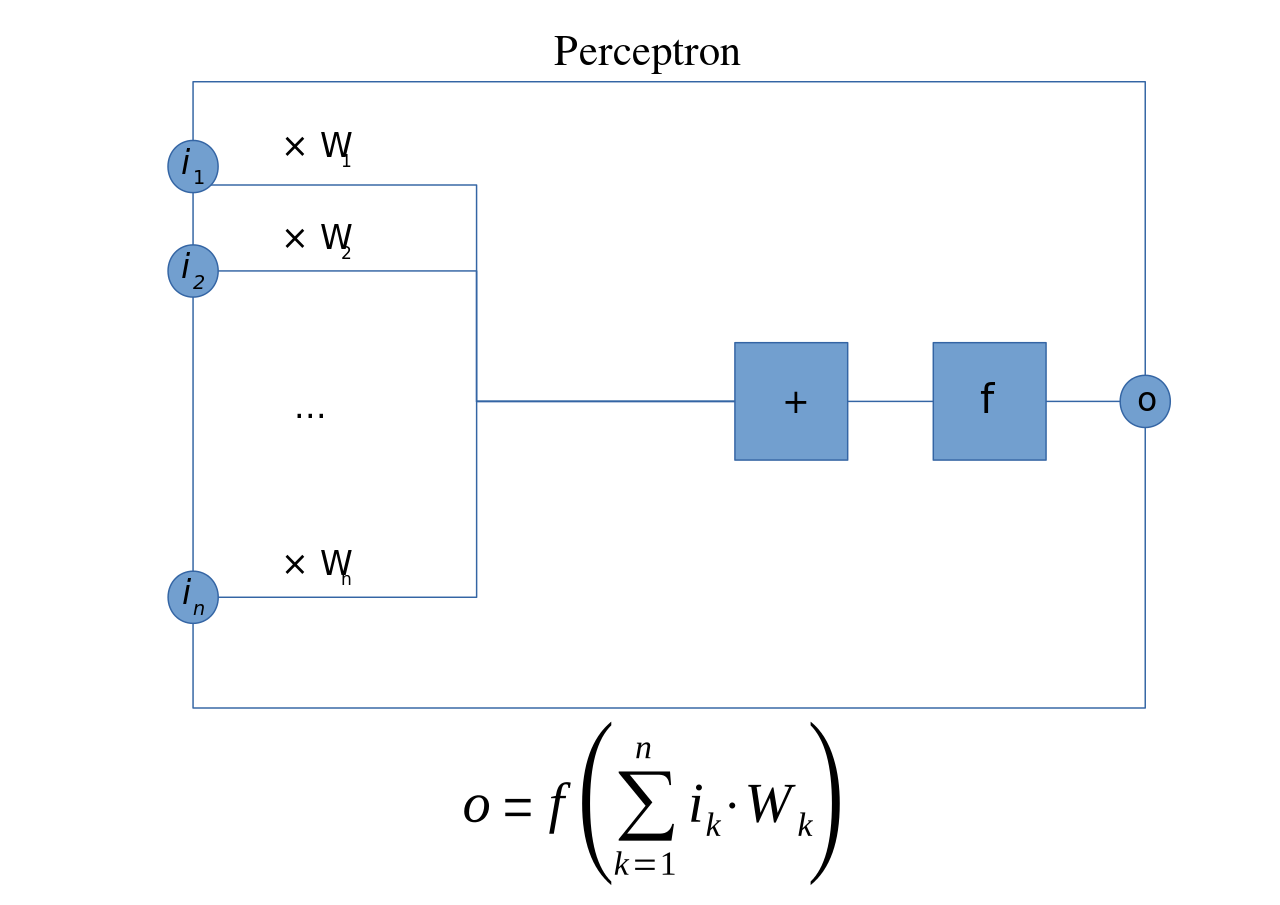

- 신경망 모형은 위와 같이 입력 데이터를 종합하여 결과값을 내는 구조를 가진 Perceptron을 중첩시키고 혼합시킨 구조이다. 아래와 같이 두 부분으로 나누어볼 수 있다.
 - 입력값들의 선형합 구조인 transfer function
 - activation function f()
- 이 때 입력값은 다른 perceptron의 출력값이 될 수 있으며 이것이 중첩되면 아래와 같이 나타날 수 있으며 이를 신경망 모형이라 한다.
 - Input Layer: 입력 데이터가 위치하는 layer.
 - Hidden Layer: 입력 데이터 혹은 또 다른 hidden layer의 출력값을 입력값으로 하는 perceptron이 위치하는 layer.
 - Output Layer:마지막 hidden layer의 출력값을 입력값고 출력함수의 결과를 얻은 노드로 구성된 layer.

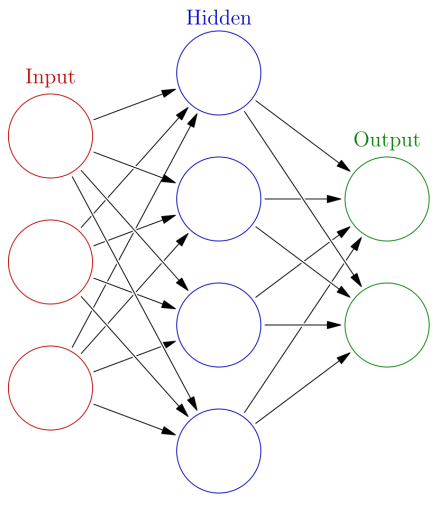

### 문제 21. [ANN] 신경망 모형  기본 모형 만들기

In [107]:
from sklearn.neural_network import MLPClassifier

In [108]:
# (문제) 신경망 모형을 만들어 ann_model에 저장합니다.

ann_model = MLPClassifier(random_state=42)

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

### 문제 22. [ANN] Grid Search 구축 (Hidden Layer 수 / Hidden node 수 / Regularization)

- 히든레이어는 많은 경우 1개로도 충분함.
- 히든 노드의 수는 아래와 같은 가이드라인 또한 존재하나, grid search를 통해서 찾는 것을 추천함.

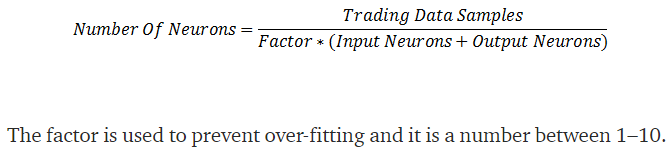

In [109]:
X_train.shape

(1552, 26)

In [110]:
X_train.shape[0]/(10*(26+1)) # 최소 5개

5.7481481481481485

In [112]:
X_train.shape[0]/(1*(26+1)) # 최대 60개

57.48148148148148

In [113]:
# (문제) 신경망 모형에서 고려해야할 alpha, hidden_layer_sizes, activation등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.

params = {
    'alpha' : [1e-3, 1e-1, 1e1],
    'hidden_layer_sizes' : [(5), (20), (40), (60)],
    'activation' : ['tanh', 'relu'],
    'solver' : ['adam', 'lbfgs']
}

### 문제 23. [ANN] 모형 평가 및 최적 신경망 모형 구축

In [116]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.

grid_ann = GridSearchCV(ann_model, param_grid=params,n_jobs=-1, scoring='accuracy')

grid_ann.fit(X_train, y_train)
grid_ann.score(X_test, y_test)

0.9845758354755784

https://playground.tensorflow.org

In [126]:
# 최적의 파라미터 값 및 정확도 (Accuracy) 출력
print('final params', grid_ann.best_params_, '\n')   
print('best score', grid_ann.best_score_)  
print('Test Score', grid_ann.score(X_test, y_test))

final params {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 60, 'solver': 'lbfgs'} 

best score 0.9800290426304326
Test Score 0.9845758354755784


In [125]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = grid_ann.cv_results_['mean_test_score']
stds = grid_ann.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_ann.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.969 (+/-0.017) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 5, 'solver': 'adam'}
0.972 (+/-0.017) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 5, 'solver': 'lbfgs'}
0.974 (+/-0.022) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 20, 'solver': 'adam'}
0.976 (+/-0.021) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'}
0.974 (+/-0.023) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 40, 'solver': 'adam'}
0.976 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 40, 'solver': 'lbfgs'}
0.976 (+/-0.018) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 60, 'solver': 'adam'}
0.979 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 60, 'solver': 'lbfgs'}
0.970 (+/-0.019) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 5, 'solver': 'adam'}
0.975 (+/-0.011) for {'activation': 'tanh', 'alpha': 0.1, 'hidden

In [128]:
params = {
    'alpha' : [0.1],
    'hidden_layer_sizes' : [(30, 1), (30, 2), (60, 1), (60, 2)],
    'activation' : ['tanh'],
    'solver' : ['lbfgs']
}

grid_ann2 = GridSearchCV(ann_model, param_grid=params,n_jobs=-1, scoring='accuracy')

grid_ann2.fit(X_train, y_train)

means = grid_ann2.cv_results_['mean_test_score']
stds = grid_ann2.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_ann2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

0.978 (+/-0.018) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (30, 1), 'solver': 'lbfgs'}
0.977 (+/-0.017) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (30, 2), 'solver': 'lbfgs'}
0.977 (+/-0.018) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (60, 1), 'solver': 'lbfgs'}
0.980 (+/-0.017) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (60, 2), 'solver': 'lbfgs'}



In [130]:
# 최적의 파라미터 값 및 정확도 (Accuracy) 출력
print('final params', grid_ann2.best_params_, '\n')   
print('best score', grid_ann2.best_score_)  
print('Test Score', grid_ann2.score(X_test, y_test))

final params {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (60, 2), 'solver': 'lbfgs'} 

best score 0.9800269681568302
Test Score 0.9820051413881749


In [131]:
y_pred = grid_ann2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       311
           1       0.92      1.00      0.96        78

    accuracy                           0.98       389
   macro avg       0.96      0.99      0.97       389
weighted avg       0.98      0.98      0.98       389



## Step 7. Boosting

- 오분류된 데이터에 가중치를 더 주어 샘플링하여 이를 잘 분류하기 위한 합성 분류기를 구성하는 방법

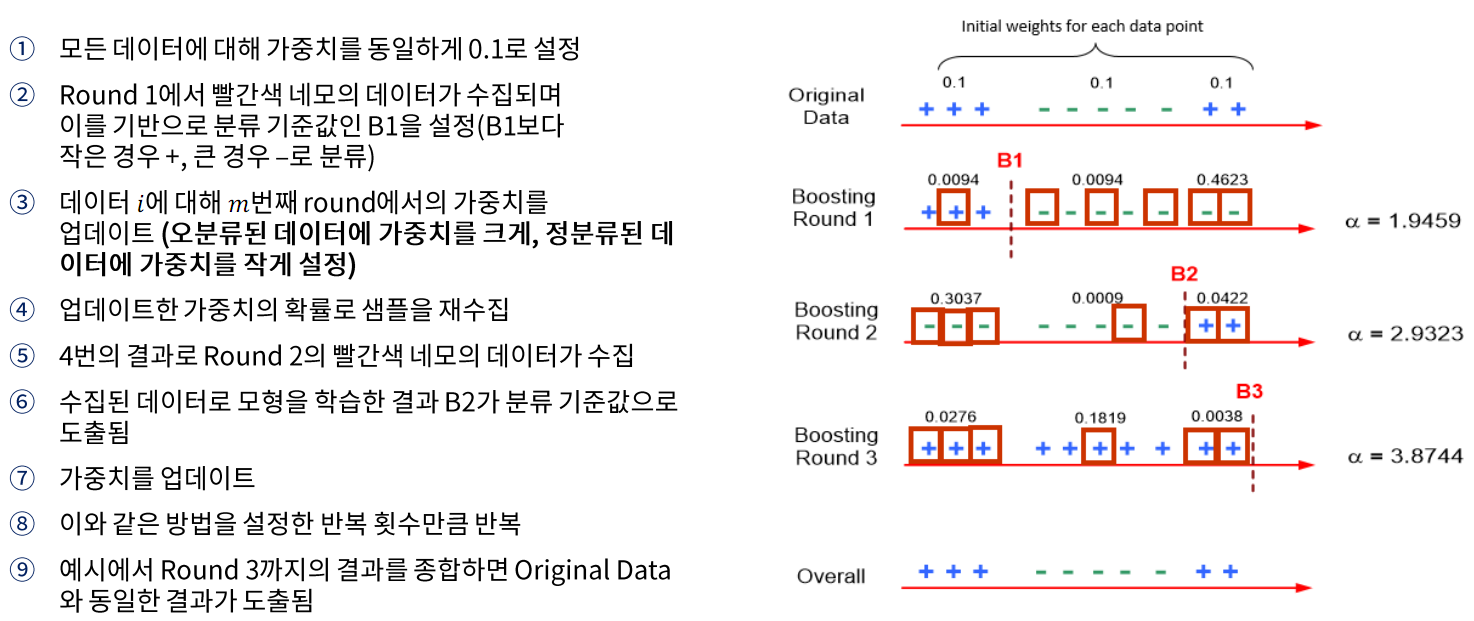

Image reference: Fastcampus 머신러닝과 데이터 분석 A-Z 이경택 강사





### 문제 24. [Boosting] xgboost 기본 모형 만들기

- xgboost는 기본적인 gradient boosting에 과정합을 방지하기 위한 regularization term이 추가된 형태.

In [136]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [134]:
# (문제) xgboost 모형을 만들어 xgb_model에 저장합니다. objective='binary:logistic'로 설정합니다.

model_xgb = xgb.XGBClassifier(objective='binary:logistic')

https://xgboost.readthedocs.io/en/latest/parameter.html

### 문제 25. [Boosting] xgboost Grid Search 구축 (Max depth / Tree 개수/ Gamma)

In [137]:
# (문제) xgboost에서 고려해야할 max_depth, min_child_weight, gamma, colsample_bytree, n_estimators 등을 고려하여 Grid search를 수행합니다.
# GridSearchCV의 옵션은 cv=10, n_jobs=n_thread, scoreing="accuracy"로 설정합니다.

params = {
    'max_depth' : [5, 8],
    'min_child_weight' : [1, 5],
    'gamma' : [0, 1],
    'colsample_bytree' : [0.8, 1]
}

random_xgb = RandomizedSearchCV(model_xgb, param_distributions=params)
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...onehot=None,
                                           max_delta_step=None, max_depth=None,
                      

https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

### 문제 26. [Boosting] 모형 평가 및 최적 xgboost 모형 구축

In [142]:
print(f'Best Score : {random_xgb.best_score_}')
print(f'Test Score : {random_xgb.score(X_test, y_test)}')
print(f'Best Prams : {random_xgb.best_params_}')


Best Score : 0.9858230474017219
Test Score : 0.987146529562982
Best Prams : {'min_child_weight': 1, 'max_depth': 5, 'gamma': 0, 'colsample_bytree': 0.8}


In [143]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
y_pred = random_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       311
           1       0.94      1.00      0.97        78

    accuracy                           0.99       389
   macro avg       0.97      0.99      0.98       389
weighted avg       0.99      0.99      0.99       389



### 문제 27. [Boosting] lightGBM 기본 모형 만들기

- xgboost에 비교할 때 성능은 비슷함.
- leaf-wise loss를 사용함. 
  - 시간과 메모리를 절약하여, fitting 속도 빠름.
  - 데이터의 수가 충분하지 않다면 과적합의 위험이 좀 더 높음.

In [144]:
import lightgbm as lgb

In [150]:
# (문제) lightgbm 모형을 만들어 lgbm_model에 저장합니다. objective='binary' 로 설정합니다.
model_lgbm = lgb.LGBMClassifier(objective='binary')

params = {
    "max_leaves" : [8,32, 64, 128], # max_leaves : [2 ** max_depth]
    "min_data_in_leaf" : [5, 10, 15, 20],
    'colsample_byree': [0.8, 1]
}

random_lgbm = RandomizedSearchCV(model_lgbm, params, cv=10, n_jobs=-1)
random_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(objective='binary'),
                   n_jobs=-1,
                   param_distributions={'colsample_byree': [0.8, 1],
                                        'max_leaves': [8, 32, 64, 128],
                                        'min_data_in_leaf': [5, 10, 15, 20]})

https://lightgbm.readthedocs.io/en/latest/Parameters.html

###문제 28. [Boosting] lightGBM  Grid Search 구축 (Max depth / Tree 개수)

In [152]:
print(f'Best Score : {random_lgbm.best_score_}')
print(f'Test Score : {random_lgbm.score(X_test, y_test)}')
print(f'Best Prams : {random_lgbm.best_params_}')

Best Score : 0.9871009098428454
Test Score : 0.9820051413881749
Best Prams : {'min_data_in_leaf': 10, 'max_leaves': 32, 'colsample_byree': 1}


https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

### 문제 29. [Boosting] 모형 평가 및 최적 lightGBM 모형 구축

In [153]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장하고 이를 출력하며 classification_report 또한 출력합니다.
y_pred = random_lgbm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       311
           1       0.92      1.00      0.96        78

    accuracy                           0.98       389
   macro avg       0.96      0.99      0.97       389
weighted avg       0.98      0.98      0.98       389



## Chapter 1. 요약 및 마무리
- 학습한 것:
 - 기초 학습 내용은 각 모델들의 구축과정, 이 파라미터를 최적화 시키는 GridSearch에 대한 활용입니다. 이는 본 강의를 통하여 100% 학습하셨을 것입니다.
 - 심화 학습 내용은 위의 내용들을 데이터의 특성과 모델 방법론에 대한 개괄적 이해를 바탕으로 한 적정한 모델의 선택과 파라미터를 최적화 시키는 관점에서 바라보고 이해하는 것입니다. 

- 본 강의의 활용:
 - 제가 각 방법론의 최적 모형을 구축하면서 코멘트 드렸던 모형 별 중요 파라미터와 이 파라미터들이 가지는 의미, 파라미터들의 변화에 따른 예측력의 변화 경향성을 바탕으로 여러 데이터에서 데이터의 특성에 따른 모델의 성능과 최적 파라미터가 가지는 경향성을 경험적으로 익히시는 것이 필요합니다.
